In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
import datetime

# for feature selection
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [31]:
infile = "weekly_regression_thread_data.p"
outfile = 'weekly_model_feature_selection.xlsx'
SCORING_METHOD = 'roc_auc'
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'all_activity', 'hour',
    'time_in_secs', 'num_dayofweek','activity_ratio'
    ]
Y_COL = 'success'



In [29]:
def logit_forward_sequential_selection(X_train, X_test, y_train, y_test, name=''):
    
    max_k = len(X_train.columns)
    k=(1, max_k)

    sfs = SequentialFeatureSelector(
        linear_model.LogisticRegression(),
        k_features = k,
        forward=True,
        scoring=SCORING_METHOD,
        cv=None,
        )
    
    selected_features = sfs.fit(X_train, y_train)
    print(f'selected features: {selected_features.k_feature_names_}')
    metric_df = pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index')
    display(metric_df)

    # Generate the new subsets based on the selected features
    # Note that the transform call is equivalent to
    # X_train[:, sfs1.k_feature_idx_]
    X_train_sfs = selected_features.transform(X_train)
    X_test_sfs = selected_features.transform(X_test)

    # Fit the estimator using the new feature subset
    # and make a prediction on the test data
    logit = linear_model.LogisticRegression()
    logit.fit(X_train_sfs, y_train)
    y_pred = logit.predict_proba(X_test_sfs)[:,1]

    # Compute the AUC of the prediction
    auc = metrics.roc_auc_score(y_test,  y_pred)
    print('Test set ROC AUC: %.2f' % (auc))
    

    fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
    plt.title(f'{name} Sequential Forward Selection (w. StdDev)')
    plt.ylabel('Performance - roc auc')
    plt.show()
    results = {
        'prev_week_metric_df': metric_df,
        'prev_week_selected_features': selected_features.k_feature_names_,
        'this_week_auc': auc
    }
    return results

In [19]:
def float_seconds(time_row):
    hours = time_row.hour
    minutes = time_row.minute
    seconds = time_row.second
    return hours*60*60 + minutes*60 + seconds

def get_dayofweek(timestamp):
    return timestamp.dayofweek

def get_hour(timestamp):
    return timestamp.hour

In [5]:
regression_thread_data = pickle.load(open(infile, 'rb'))

In [22]:

for subr in regression_thread_data:
    for key in regression_thread_data[subr]:
        regression_thread_data[subr][key]['time_in_secs'] = regression_thread_data[subr][key].timestamp.apply(float_seconds)
        regression_thread_data[subr][key]['num_dayofweek'] = regression_thread_data[subr][key].timestamp.apply(get_dayofweek)
        regression_thread_data[subr][key]['hour'] = regression_thread_data[subr][key].timestamp.apply(get_hour)


In [28]:
list(regression_thread_data['books'])[:-1]

[0, 1, 2]


### books ###
selected features: ('all_activity', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7756568226082119],0.775657,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.7885090822369729],0.788509,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(2, 5, 6)",[0.7944512897968918],0.794451,"(all_activity, num_dayofweek, activity_ratio)",NaN,0.0,NaN
4,"(1, 2, 5, 6)",[0.7899956278071465],0.789996,"(sentiment_magnitude, all_activity, num_dayofw...",NaN,0.0,NaN
5,"(1, 2, 3, 5, 6)",[0.7868953456019715],0.786895,"(sentiment_magnitude, all_activity, hour, num_...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.7819189951905878],0.781919,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6515203306967685],0.651520,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.78


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


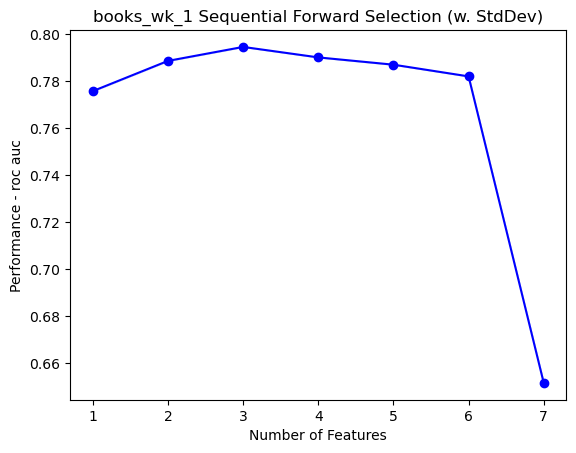

selected features: ('sentiment_sign', 'sentiment_magnitude', 'all_activity', 'hour', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7675722733480633],0.767572,"(activity_ratio,)",NaN,0.0,NaN
2,"(1, 6)",[0.7822879350165532],0.782288,"(sentiment_magnitude, activity_ratio)",NaN,0.0,NaN
3,"(1, 2, 6)",[0.7899246340748368],0.789925,"(sentiment_magnitude, all_activity, activity_r...",NaN,0.0,NaN
4,"(1, 2, 3, 6)",[0.7937125941180256],0.793713,"(sentiment_magnitude, all_activity, hour, acti...",NaN,0.0,NaN
5,"(1, 2, 3, 5, 6)",[0.7957915924805685],0.795792,"(sentiment_magnitude, all_activity, hour, num_...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.7965388163116459],0.796539,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.5817655933815274],0.581766,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.77


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


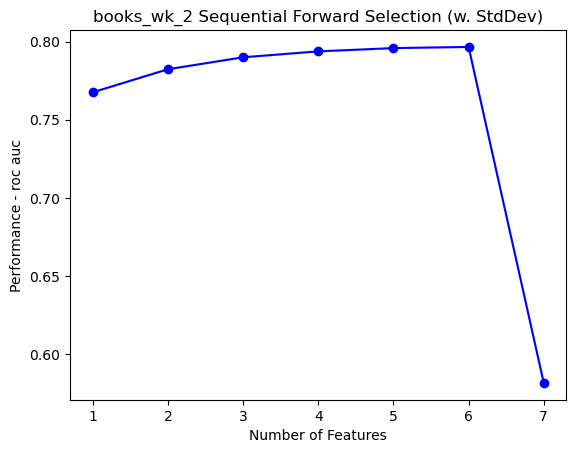

selected features: ('sentiment_sign', 'sentiment_magnitude', 'all_activity', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7588332157139496],0.758833,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.7713680814598247],0.771368,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(2, 5, 6)",[0.7772876970124677],0.777288,"(all_activity, num_dayofweek, activity_ratio)",NaN,0.0,NaN
4,"(1, 2, 5, 6)",[0.7751251806297678],0.775125,"(sentiment_magnitude, all_activity, num_dayofw...",NaN,0.0,NaN
5,"(0, 1, 2, 5, 6)",[0.7791528043821622],0.779153,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.7773834727963168],0.777383,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6151964243707364],0.615196,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.78


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


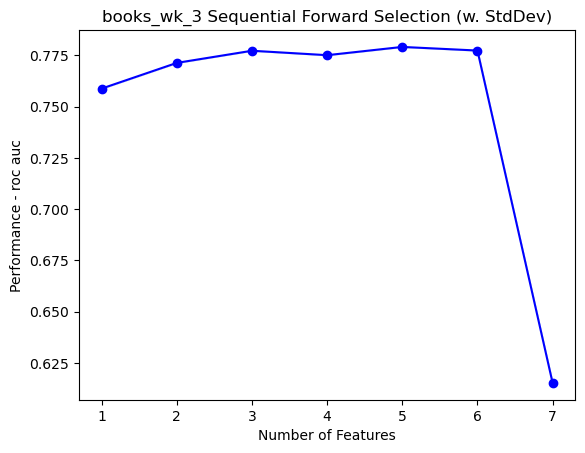


### conspiracy ###
selected features: ('sentiment_sign', 'sentiment_magnitude', 'all_activity', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.8053485389219718],0.805349,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.8183470642751445],0.818347,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(1, 2, 6)",[0.8193743247602419],0.819374,"(sentiment_magnitude, all_activity, activity_r...",NaN,0.0,NaN
4,"(0, 1, 2, 6)",[0.8197077843943452],0.819708,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
5,"(0, 1, 2, 5, 6)",[0.8190395850507678],0.819040,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.817751829227705],0.817752,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.613479961700145],0.613480,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.81


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


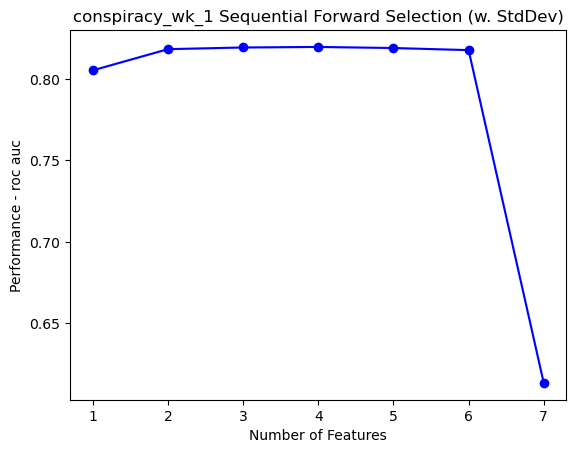

selected features: ('all_activity', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.8079773511069476],0.807977,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.8200955098833937],0.820096,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(2, 5, 6)",[0.8189481447625379],0.818948,"(all_activity, num_dayofweek, activity_ratio)",NaN,0.0,NaN
4,"(0, 2, 5, 6)",[0.8174707351069175],0.817471,"(sentiment_sign, all_activity, num_dayofweek, ...",NaN,0.0,NaN
5,"(0, 1, 2, 5, 6)",[0.8160339317889074],0.816034,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.8155546825717599],0.815555,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6282102615048143],0.628210,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.80


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


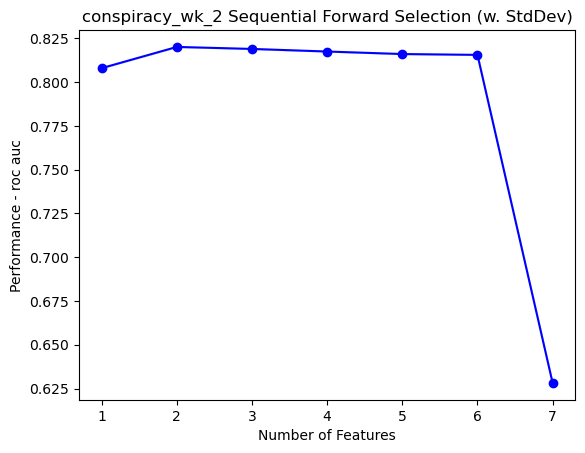

selected features: ('all_activity', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7918797117129694],0.791880,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.8000592236144073],0.800059,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(1, 2, 6)",[0.798899836835125],0.798900,"(sentiment_magnitude, all_activity, activity_r...",NaN,0.0,NaN
4,"(1, 2, 3, 6)",[0.799561330797152],0.799561,"(sentiment_magnitude, all_activity, hour, acti...",NaN,0.0,NaN
5,"(0, 1, 2, 3, 6)",[0.7997216599190283],0.799722,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.7996562194611196],0.799656,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6038660041183861],0.603866,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.84


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


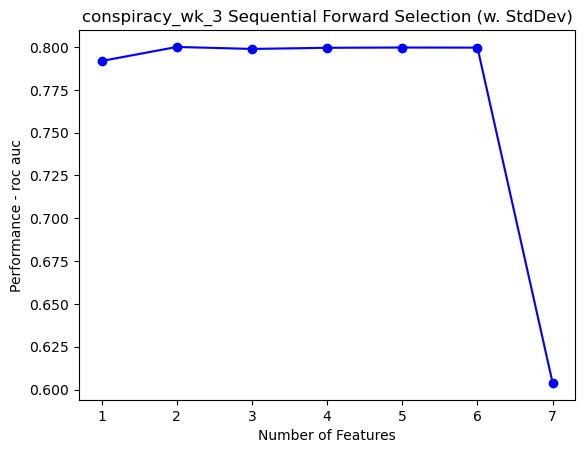


### crypto ###
selected features: ('sentiment_sign', 'all_activity', 'hour', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7960195284684622],0.796020,"(activity_ratio,)",NaN,0.0,NaN
2,"(0, 6)",[0.8003283488177354],0.800328,"(sentiment_sign, activity_ratio)",NaN,0.0,NaN
3,"(0, 2, 6)",[0.8006306601266374],0.800631,"(sentiment_sign, all_activity, activity_ratio)",NaN,0.0,NaN
4,"(0, 2, 5, 6)",[0.800773815899655],0.800774,"(sentiment_sign, all_activity, num_dayofweek, ...",NaN,0.0,NaN
5,"(0, 2, 3, 5, 6)",[0.801244208927935],0.801244,"(sentiment_sign, all_activity, hour, num_dayof...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.8007421532110345],0.800742,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.695369904412364],0.695370,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.82


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


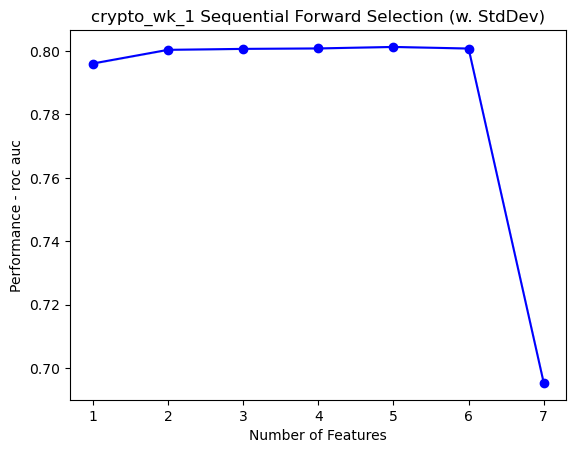

selected features: ('sentiment_magnitude', 'hour', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.8174062703349243],0.817406,"(activity_ratio,)",NaN,0.0,NaN
2,"(5, 6)",[0.8217018558193349],0.821702,"(num_dayofweek, activity_ratio)",NaN,0.0,NaN
3,"(1, 5, 6)",[0.8228021291886759],0.822802,"(sentiment_magnitude, num_dayofweek, activity_...",NaN,0.0,NaN
4,"(1, 3, 5, 6)",[0.8229254766973448],0.822925,"(sentiment_magnitude, hour, num_dayofweek, act...",NaN,0.0,NaN
5,"(0, 1, 3, 5, 6)",[0.8229173214901603],0.822917,"(sentiment_sign, sentiment_magnitude, hour, nu...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.8225437110610094],0.822544,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.7169833888623657],0.716983,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.82


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


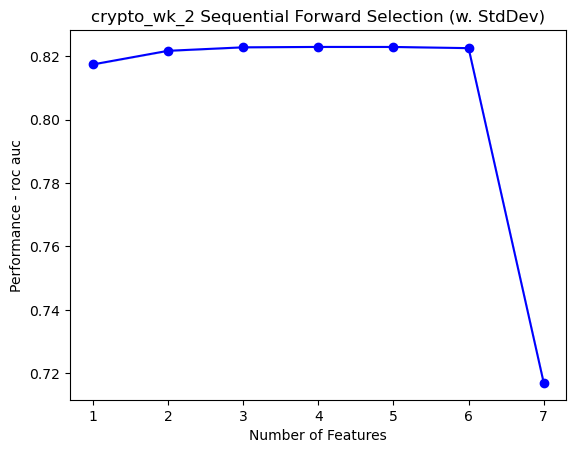

selected features: ('sentiment_magnitude', 'all_activity', 'hour', 'time_in_secs', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.8134429396013719],0.813443,"(activity_ratio,)",NaN,0.0,NaN
2,"(1, 6)",[0.8153187389262652],0.815319,"(sentiment_magnitude, activity_ratio)",NaN,0.0,NaN
3,"(1, 3, 6)",[0.815561786448273],0.815562,"(sentiment_magnitude, hour, activity_ratio)",NaN,0.0,NaN
4,"(1, 2, 3, 6)",[0.8155384237407312],0.815538,"(sentiment_magnitude, all_activity, hour, acti...",NaN,0.0,NaN
5,"(1, 2, 3, 4, 6)",[0.8156682374947339],0.815668,"(sentiment_magnitude, all_activity, hour, time...",NaN,0.0,NaN
6,"(1, 2, 3, 4, 5, 6)",[0.815851370976433],0.815851,"(sentiment_magnitude, all_activity, hour, time...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.8140441525027112],0.814044,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.82


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


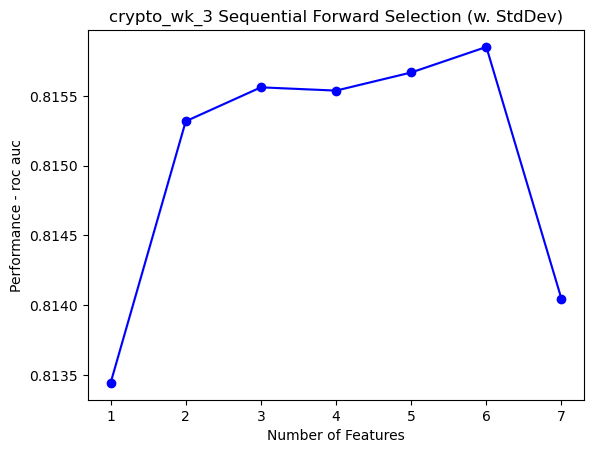


### politics ###
selected features: ('all_activity',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6677814754656556],0.667781,"(all_activity,)",NaN,0.0,NaN
2,"(2, 6)",[0.6508426778878009],0.650843,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(2, 5, 6)",[0.6395530891095487],0.639553,"(all_activity, num_dayofweek, activity_ratio)",NaN,0.0,NaN
4,"(0, 2, 5, 6)",[0.63947437743871],0.639474,"(sentiment_sign, all_activity, num_dayofweek, ...",NaN,0.0,NaN
5,"(0, 2, 3, 5, 6)",[0.6415601360616212],0.641560,"(sentiment_sign, all_activity, hour, num_dayof...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.6433971922623868],0.643397,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.5915831715195465],0.591583,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.68


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


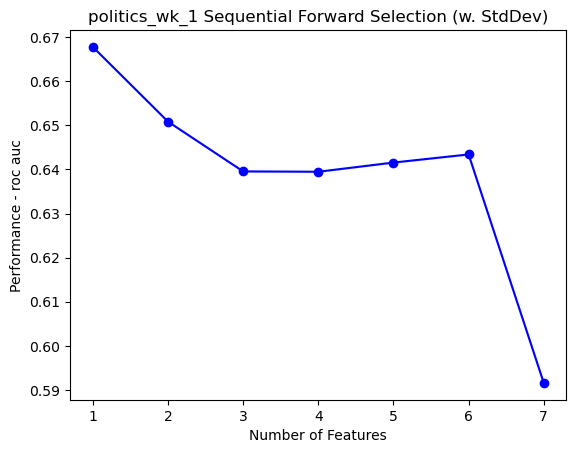

selected features: ('all_activity',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6815548896904102],0.681555,"(all_activity,)",NaN,0.0,NaN
2,"(2, 6)",[0.6617501095852709],0.661750,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(0, 2, 6)",[0.6529649455873352],0.652965,"(sentiment_sign, all_activity, activity_ratio)",NaN,0.0,NaN
4,"(0, 1, 2, 6)",[0.6481977831965251],0.648198,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
5,"(0, 1, 2, 3, 6)",[0.6452346062223435],0.645235,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.6507323058378358],0.650732,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6018957720646365],0.601896,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.66


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


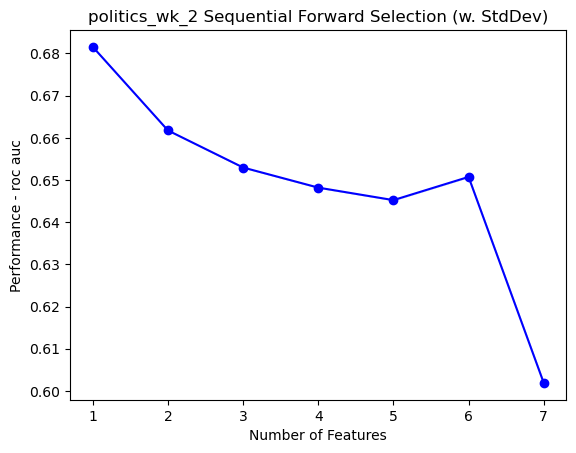

selected features: ('sentiment_sign', 'all_activity', 'hour', 'num_dayofweek', 'activity_ratio')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6622610819467147],0.662261,"(all_activity,)",NaN,0.0,NaN
2,"(2, 6)",[0.6280846444130394],0.628085,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(2, 3, 6)",[0.6583348390395035],0.658335,"(all_activity, hour, activity_ratio)",NaN,0.0,NaN
4,"(0, 2, 3, 6)",[0.6609625751408216],0.660963,"(sentiment_sign, all_activity, hour, activity_...",NaN,0.0,NaN
5,"(0, 2, 3, 5, 6)",[0.6627740866852786],0.662774,"(sentiment_sign, all_activity, hour, num_dayof...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.6626784211114403],0.662678,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.5685035470787171],0.568504,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


Test set ROC AUC: 0.67


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


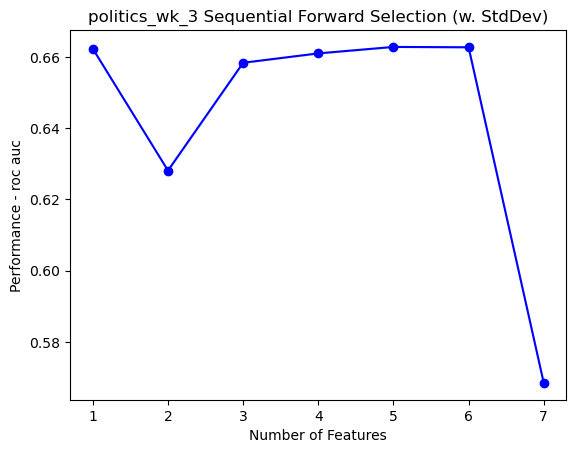

selected features: ('all_activity',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6994049565268511],0.699405,"(all_activity,)",NaN,0.0,NaN
2,"(2, 6)",[0.6983162948181645],0.698316,"(all_activity, activity_ratio)",NaN,0.0,NaN
3,"(0, 2, 6)",[0.6939611856085152],0.693961,"(sentiment_sign, all_activity, activity_ratio)",NaN,0.0,NaN
4,"(0, 1, 2, 6)",[0.6896229200560398],0.689623,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
5,"(0, 1, 2, 4, 6)",[0.6883894359224345],0.688389,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 4, 6)",[0.6829426595672303],0.682943,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6536839059846505],0.653684,"(sentiment_sign, sentiment_magnitude, all_acti...",NaN,0.0,NaN


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LogisticRegression.

In [33]:
FSS_metrics = {}
for key in regression_thread_data:
    print(f'\n### {key} ###')
    FSS_metrics[key] = {}
    for week in list(regression_thread_data[key])[:-1]:
        X_train = regression_thread_data[key][week][X_COLS]
        X_test = regression_thread_data[key][week + 1][X_COLS]
        y_train = regression_thread_data[key][week][Y_COL]
        y_test = regression_thread_data[key][week + 1][Y_COL]
        FSS_metrics[key][week+1] = logit_forward_sequential_selection(X_train, X_test, y_train, y_test, name=f"{key}_wk_{week+1}")

In [42]:
regression_thread_data['politics'][5]

,thread_id,thread_size,authors,timestamp,score,subject_sentiment_score,sentiment_sign,sentiment_magnitude,success,author,all_activity,comments,posts,activity_ratio,time_in_secs,num_dayofweek,hour


In [16]:
FSS_metrics

{'books': {'metric_df':                        feature_idx             cv_scores  avg_score  \
  1                             (8,)  [0.7712577898006212]   0.771258   
  2                           (4, 8)  [0.7835030558060314]   0.783503   
  3                        (2, 4, 8)  [0.7834631800420802]   0.783463   
  4                     (2, 4, 8, 9)  [0.7834689910830579]   0.783469   
  5                  (2, 3, 4, 8, 9)  [0.7834689910830579]   0.783469   
  6               (2, 3, 4, 5, 8, 9)  [0.7820821560965836]   0.782082   
  7            (1, 2, 3, 4, 5, 8, 9)  [0.7815218915940286]   0.781522   
  8         (0, 1, 2, 3, 4, 5, 8, 9)  [0.7811580002003806]   0.781158   
  9      (0, 1, 2, 3, 4, 5, 7, 8, 9)  [0.7805606652640016]   0.780561   
  10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)  [0.7559633303276225]   0.755963   
  
                                          feature_names  ci_bound  std_dev  \
  1                                   (activity_ratio,)       NaN      0.0   
  2             

In [17]:
i = 0
other_feats_dict = {}
for key in FSS_metrics:
    df = FSS_metrics[key]['metric_df'][['feature_idx', 'cv_scores', 'avg_score', 'feature_names']].reset_index().rename(columns={'index': 'number_features'})
    df.loc[:,'subreddit'] = key
    if i == 0:
        FSS_metrics_df = df
        i += 1
    else:
        FSS_metrics_df = pd.concat((FSS_metrics_df, df))
    FSS_metrics[key].pop('metric_df')

FSS_metrics_df


,number_features,feature_idx,cv_scores,avg_score,feature_names,subreddit
0,1,"(8,)",[0.7712577898006212],0.771258,"(activity_ratio,)",books
1,2,"(4, 8)",[0.7835030558060314],0.783503,"(all_activity_count, activity_ratio)",books
2,3,"(2, 4, 8)",[0.7834631800420802],0.783463,"(post_activity_count, all_activity_count, acti...",books
3,4,"(2, 4, 8, 9)",[0.7834689910830579],0.783469,"(post_activity_count, all_activity_count, acti...",books
4,5,"(2, 3, 4, 8, 9)",[0.7834689910830579],0.783469,"(post_activity_count, comment_activity_count, ...",books
5,6,"(2, 3, 4, 5, 8, 9)",[0.7820821560965836],0.782082,"(post_activity_count, comment_activity_count, ...",books
6,7,"(1, 2, 3, 4, 5, 8, 9)",[0.7815218915940286],0.781522,"(sentiment_magnitude, post_activity_count, com...",books
7,8,"(0, 1, 2, 3, 4, 5, 8, 9)",[0.7811580002003806],0.781158,"(sentiment_sign, sentiment_magnitude, post_act...",books
8,9,"(0, 1, 2, 3, 4, 5, 7, 8, 9)",[0.7805606652640016],0.780561,"(sentiment_sign, sentiment_magnitude, post_act...",books
9,10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",[0.7559633303276225],0.755963,"(sentiment_sign, sentiment_magnitude, post_act...",books


In [18]:
FSS_metrics_df.set_index(['subreddit', 'number_features'], inplace=True)

In [19]:
FSS_metrics_df

feature_idx  \
subreddit  number_features                                   
books      1                                          (8,)   
           2                                        (4, 8)   
           3                                     (2, 4, 8)   
           4                                  (2, 4, 8, 9)   
           5                               (2, 3, 4, 8, 9)   
           6                            (2, 3, 4, 5, 8, 9)   
           7                         (1, 2, 3, 4, 5, 8, 9)   
           8                      (0, 1, 2, 3, 4, 5, 8, 9)   
           9                   (0, 1, 2, 3, 4, 5, 7, 8, 9)   
           10               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
conspiracy 1                                          (8,)   
           2                                        (2, 8)   
           3                                     (2, 5, 8)   
           4                                  (2, 4, 5, 8)   
           5                               (2, 4, 5, 8, 9)   
           6                            (2, 3, 4, 5, 8, 9)   
           7                         (1, 2, 3, 4, 5, 8, 9)   
           8                      (1, 2, 3, 4, 5, 7, 8, 9)   
           9                   (0, 1, 2, 3, 4, 5, 7, 8, 9)   
           10               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
crypto     1                                          (3,)   
           2                                        (3, 9)   
           3                                     (2, 3, 9)   
           4                                  (1, 2, 3, 9)   
           5                               (1, 2, 3, 8, 9)   
           6                            (1, 2, 3, 7, 8, 9)   
           7                         (1, 2, 3, 5, 7, 8, 9)   
           8                      (1, 2, 3, 4, 5, 7, 8, 9)   
           9                   (0, 1, 2, 3, 4, 5, 7, 8, 9)   
           10               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
politics   1                                          (4,)   
           2                                        (2, 4)   
           3                                     (2, 3, 4)   
           4                                  (1, 2, 3, 4)   
           5                               (0, 1, 2, 3, 4)   
           6                            (0, 1, 2, 3, 4, 7)   
           7                         (0, 1, 2, 3, 4, 6, 7)   
           8                      (0, 1, 2, 3, 4, 6, 7, 8)   
           9                   (0, 1, 2, 3, 4, 6, 7, 8, 9)   
           10               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   

                                       cv_scores  avg_score  \
subreddit  number_features                                    
books      1                [0.7712577898006212]   0.771258   
           2                [0.7835030558060314]   0.783503   
           3                [0.7834631800420802]   0.783463   
           4                [0.7834689910830579]   0.783469   
           5                [0.7834689910830579]   0.783469   
           6                [0.7820821560965836]   0.782082   
           7                [0.7815218915940286]   0.781522   
           8                [0.7811580002003806]   0.781158   
           9                [0.7805606652640016]   0.780561   
           10               [0.7559633303276225]   0.755963   
conspiracy 1                [0.7951123702068987]   0.795112   
           2                [0.8016166486612439]   0.801617   
           3                [0.8024234625102065]   0.802423   
           4                [0.8024467516098966]   0.802447   
           5                [0.8045269436228065]   0.804527   
           6                [0.8045244763021675]   0.804524   
           7                 [0.804317823154011]   0.804318   
           8                 [0.803931055599205]   0.803931   
           9                [0.8011125931082559]   0.801113   
           10               [0.6879010298716705]   0.687901   
crypto     1                [0.8185895728905598]   0.818

In [20]:
other_metrics = pd.DataFrame.from_dict(FSS_metrics).T
other_metrics

,selected_features,test_set_auc
books,"(all_activity_count, activity_ratio)",0.790677
conspiracy,"(post_activity_count, all_activity_count, hour...",0.841772
crypto,"(sentiment_magnitude, post_activity_count, com...",0.833048
politics,"(post_activity_count, comment_activity_count, ...",0.688734


In [21]:
with pd.ExcelWriter(outfile, engine='xlsxwriter') as writer:
    FSS_metrics_df.to_excel(writer, sheet_name='FSS_metrics')
    other_metrics.to_excel(writer, sheet_name='test_sets')